In [1]:
%load_ext autoreload
%autoreload 2
from utils import *

In [2]:
path = "../"
record_names = ["MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                #"MoscowSpecialistsData/P6.edf", 
                "MoscowSpecialistsData/P8.edf", 
                "MoscowSpecialistsData/P23.edf", 
                "MoscowSpecialistsData/P27.edf",
                "MoscowSpecialistsData/P37.edf", 
                "MoscowSpecialistsData/P38.edf", 
                "MoscowSpecialistsData/P44.edf", 
                "MoscowSpecialistsData/P46.edf", 
                "MoscowSpecialistsData/P47.edf", 
                "MoscowSpecialistsData/P48.edf", 
                "MoscowSpecialistsData/P49.edf", 
                #"MoscowSpecialistsData/P50.edf",  #bad segm quality
                "MoscowSpecialistsData/P51.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal(path + file_name)
    records.append(broad_filter(sigbufs, 199))
    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

In [3]:
epi_record_names = ["MoscowSpecialistsData/P2.edf", 
                    "MoscowSpecialistsData/P3.edf", 
                    "MoscowSpecialistsData/P4.edf", 
                    "MoscowSpecialistsData/P5.edf",  
                    "MoscowSpecialistsData/P23.edf", 
                    "MoscowSpecialistsData/P27.edf",
                    "MoscowSpecialistsData/P37.edf", 
                    "MoscowSpecialistsData/P38.edf", 
                    ]

norma_record_names = [record for record in record_names if record not in epi_record_names]

In [5]:
normalized_records = [records[i].copy() for i in range(len(records))]
NormalizeAndClip(normalized_records)    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.09it/s]


In [11]:
labels = []

for i in range(len(records)):
    if "Moscow" in record_names[i]:
        labels.append(np.load(path + "MoscowSpecialistsData/Labels/" + 
                                  record_names[i][22:] + "freq" + str(freqs[i])[:3] + ".npy"))

In [7]:
exp_name = "17RecordsUnet1d"
splits_dict = ParseSplits(path + "CrossValidationResults/" + exp_name, record_names)

In [12]:
data = []
data_normalized = []
for i in range(len(records)):
    time_start = annots[i][0][0]
    time_end = annots[i][-1][0]
    idx_start = (np.array(times[i]) <= time_start).argmin()
    idx_fin = (np.array(times[i]) < time_end).argmin()        

    data.append(torch.FloatTensor(records[i][:, idx_start:idx_fin].copy()))
    data_normalized.append(torch.FloatTensor(normalized_records[i][:, idx_start:idx_fin].copy()))

    

    current_labels = labels[i][idx_start:idx_fin]
    new_trainl = torch.zeros(2, len(current_labels))
    new_trainl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
    new_trainl = new_trainl.float()
    labels[i] = new_trainl

In [13]:
unet_segm_model_predictions_epi = []
unet_segm_model_predictions_norma = []
epi_data = []
norm_data = []
epi_labels = []
norm_labels = []


model_name = "Unet1d"
exp_name = "17RecordsUnet1d"
model = UNET_1D(20,128,7,3)
for i in range(len(records)):
    split_name = splits_dict[record_names[i]]
    model.load_state_dict(torch.load(path + "CrossValidationResults/" + exp_name + "/" + split_name +"/" + model_name, 
                                     map_location=torch.device('cpu')))  
    all_preds = CollectingPreds(model, [data_normalized[i]], model_name=model_name)
    PostProcessing(all_preds[0], 30)
    if record_names[i] in epi_record_names:
        unet_segm_model_predictions_epi += all_preds
        epi_data.append(data[i])
        epi_labels.append(labels[i])

    else:
        unet_segm_model_predictions_norma += all_preds
        norm_data.append(data[i])
        norm_labels.append(labels[i])




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.31it/s]


In [14]:
unet_test_samples_char_true_epi, unet_test_samples_char_pred_epi, unet_dif_epi = CharsFromPredictions(epi_data, epi_labels, unet_segm_model_predictions_epi, overlap=0)

In [15]:
unet_test_samples_char_true_norma, unet_test_samples_char_pred_norma, unet_dif_norma = CharsFromPredictions(norm_data, norm_labels, unet_segm_model_predictions_norma, overlap=0)

# Картинки

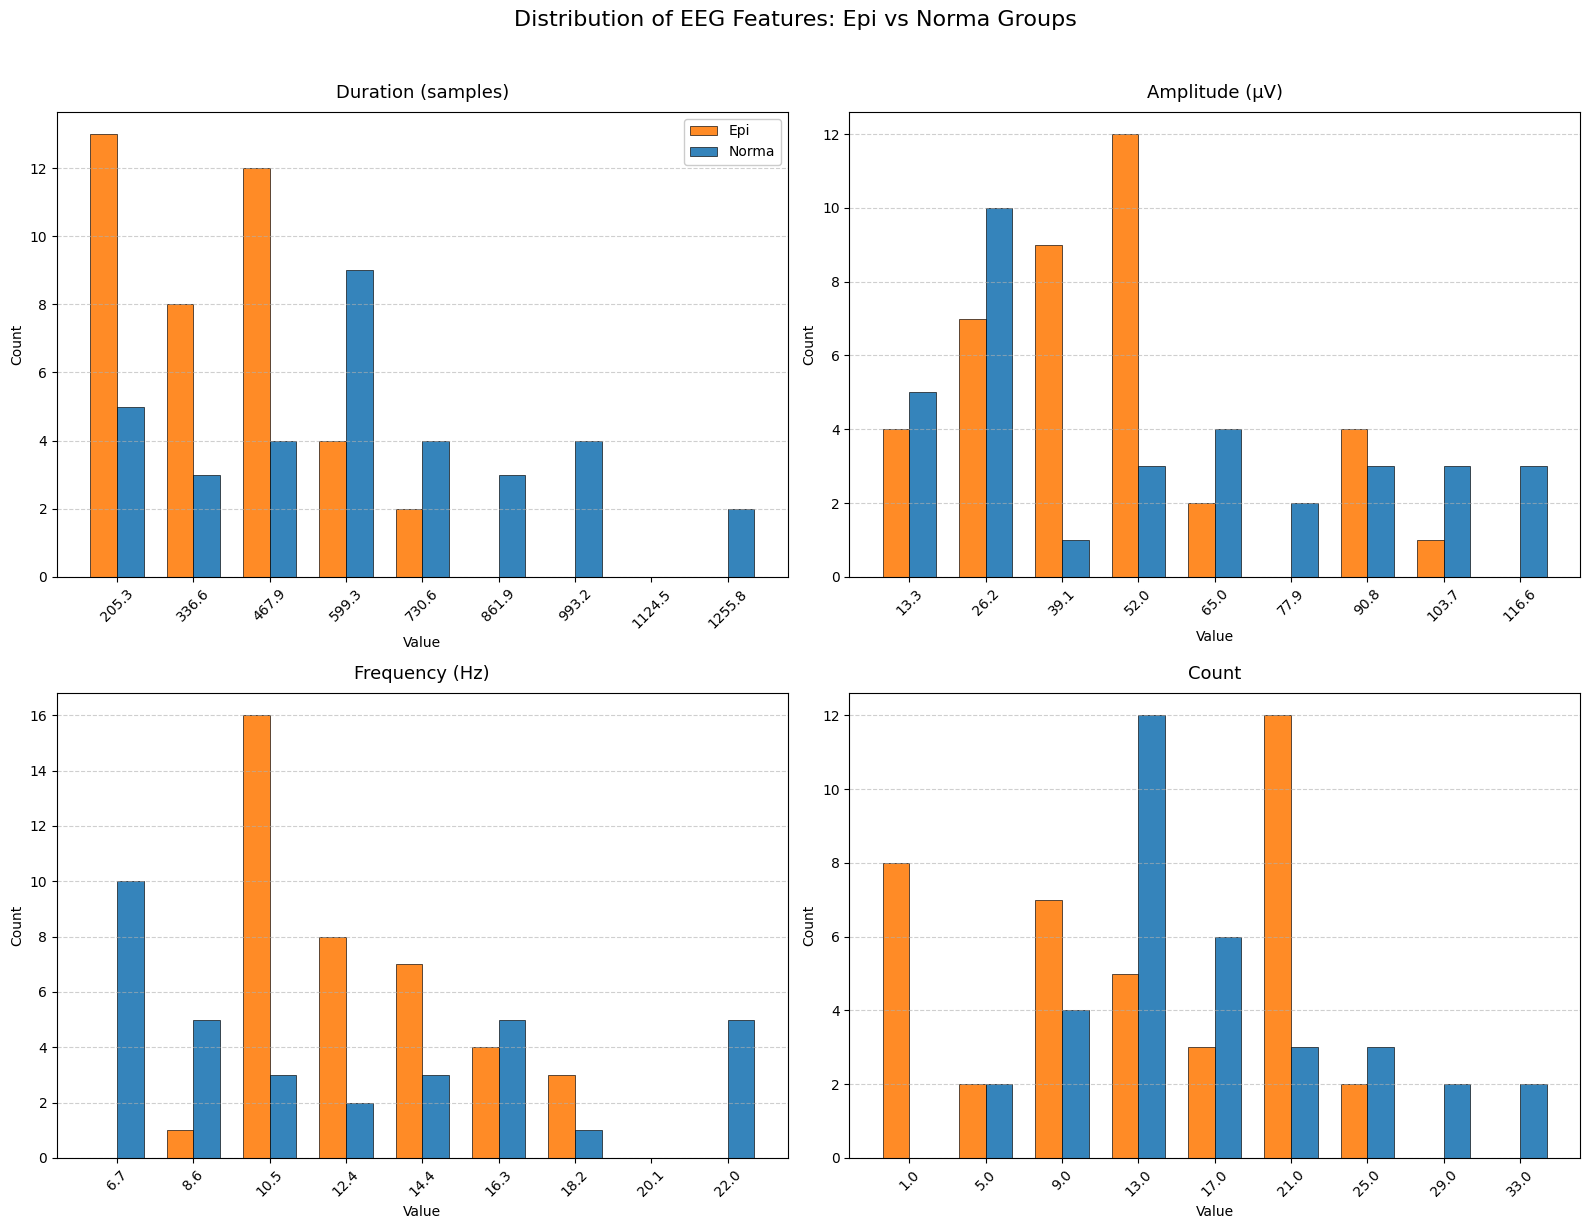

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Настройки
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
colors = ['#ff7f0e', '#1f77b4']  # синий для Epi, оранжевый для Norma
bar_width = 0.35

# Создаем 4 подграфика (2 строки x 2 столбца)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, ax in enumerate(axes.flat):
    # Подготовка данных
    epi_vals = np.ma.filled(unet_test_samples_char_true_epi[:, i], np.nan)
    norma_vals = np.ma.filled(unet_test_samples_char_true_norma[:, i], np.nan)
    
    # Общие bins для обеих групп
    combined = np.concatenate([epi_vals[~np.isnan(epi_vals)], 
                              norma_vals[~np.isnan(norma_vals)]])
    bins = np.linspace(np.min(combined), np.max(combined), 10)
    
    # Гистограммы
    hist_epi, _ = np.histogram(epi_vals, bins=bins)
    hist_norma, _ = np.histogram(norma_vals, bins=bins)
    
    # Позиции столбцов
    x = np.arange(len(bins)-1)
    
    # Столбчатые диаграммы
    ax.bar(x - bar_width/2, hist_epi, width=bar_width,
           color=colors[0], alpha=0.9, label='Epi',
           edgecolor='black', linewidth=0.5)
    ax.bar(x + bar_width/2, hist_norma, width=bar_width,
           color=colors[1], alpha=0.9, label='Norma',
           edgecolor='black', linewidth=0.5)
    
    # Оформление
    ax.set_title(metrics[i], fontsize=13, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{bins[j]:.1f}" for j in range(len(bins)-1)], rotation=45, fontsize=10)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    
    if i == 0:
        ax.legend(fontsize=10, framealpha=1)

plt.suptitle('Distribution of EEG Features: Epi vs Norma Groups', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2622202/2199069176.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/2199069176.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/2199069176.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/2199069176.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())


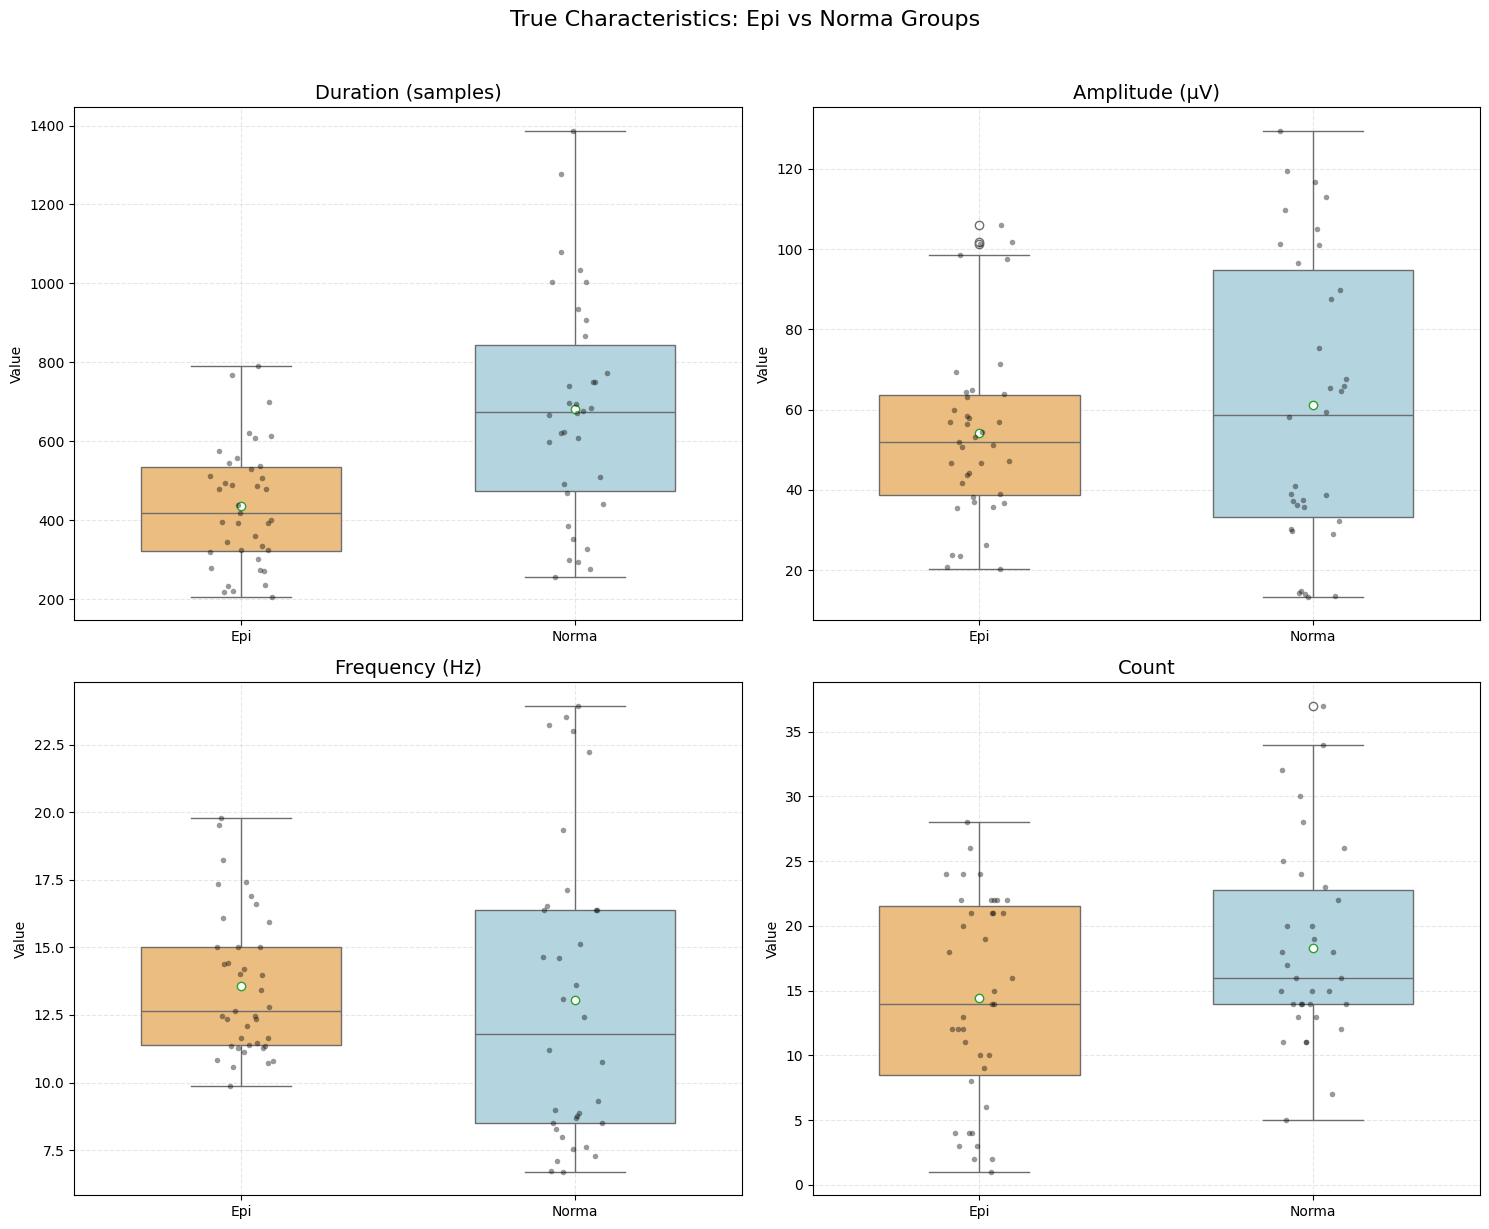

In [23]:
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    # Собираем данные
    data = {
        'Epi': unet_test_samples_char_true_epi[:, i],
        'Norma': unet_test_samples_char_true_norma[:, i]
    }
    
    # Boxplot с визуальными улучшениями
    sns.boxplot(data=list(data.values()), ax=ax, width=0.6,
                palette=['#fdbf6f', 'lightblue'],  # оранжевый для epi, синий для norma
                showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white'})
    
    # Добавляем точки для каждого наблюдения
    sns.stripplot(data=list(data.values()), ax=ax, 
                  color='black', alpha=0.4, size=4, jitter=True)
    
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xticklabels(data.keys())
    ax.set_ylabel('Value')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('True Characteristics: Epi vs Norma Groups', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2622202/384940696.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Epi', 'Norma'])
/tmp/ipykernel_2622202/384940696.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Epi', 'Norma'])
/tmp/ipykernel_2622202/384940696.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Epi', 'Norma'])
/tmp/ipykernel_2622202/384940696.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Epi', 'Norma'])


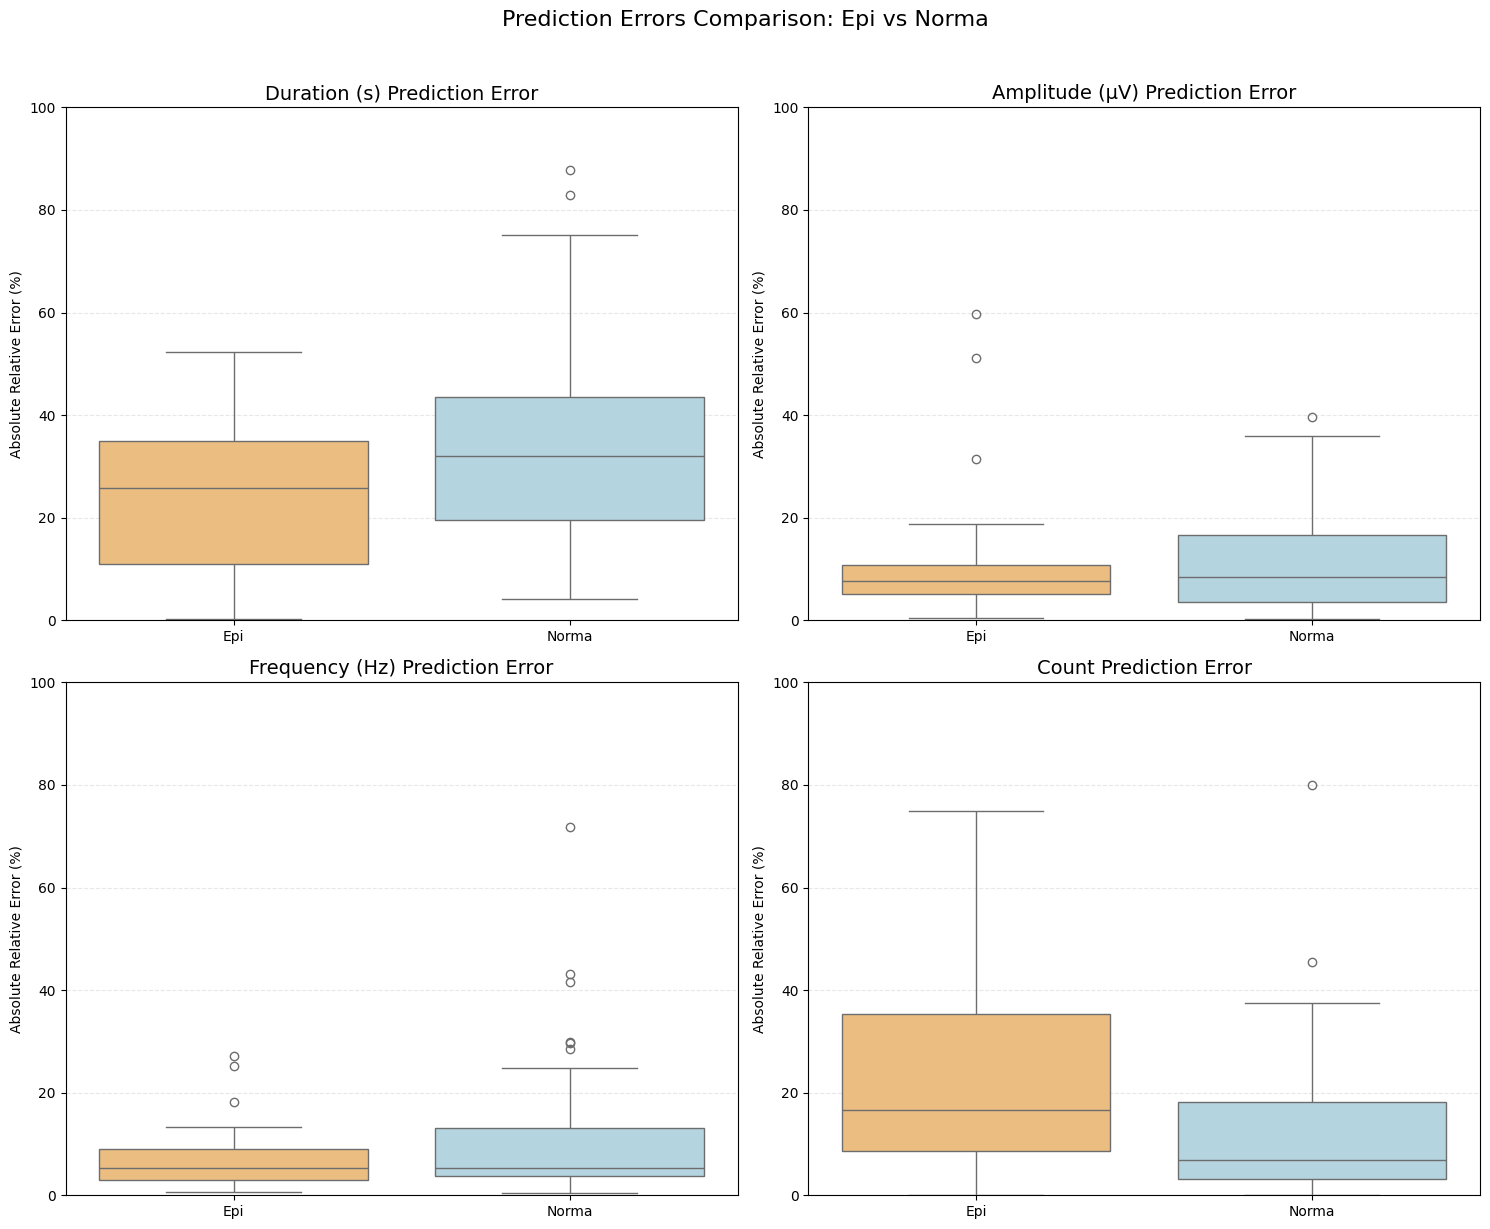

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    # Рассчитываем относительные ошибки в %
    epi_errors = np.abs(unet_dif_epi[:, i] / unet_test_samples_char_true_epi[:, i]) * 100
    norma_errors = np.abs(unet_dif_norma[:, i] / unet_test_samples_char_true_norma[:, i]) * 100
    
    # Violin plot для распределения ошибок
    sns.boxplot(data=[epi_errors, norma_errors], ax=ax,
                   palette=['#fdbf6f', 'lightblue'])
    
    ax.set_title(f'{metrics[i]} Prediction Error', fontsize=14)
    ax.set_xticklabels(['Epi', 'Norma'])
    ax.set_ylabel('Absolute Relative Error (%)')
    ax.set_ylim(0, 100)  # Фиксируем масштаб для сравнения
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.suptitle('Prediction Errors Comparison: Epi vs Norma', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2622202/3295615504.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/3295615504.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/3295615504.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())
/tmp/ipykernel_2622202/3295615504.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.keys())


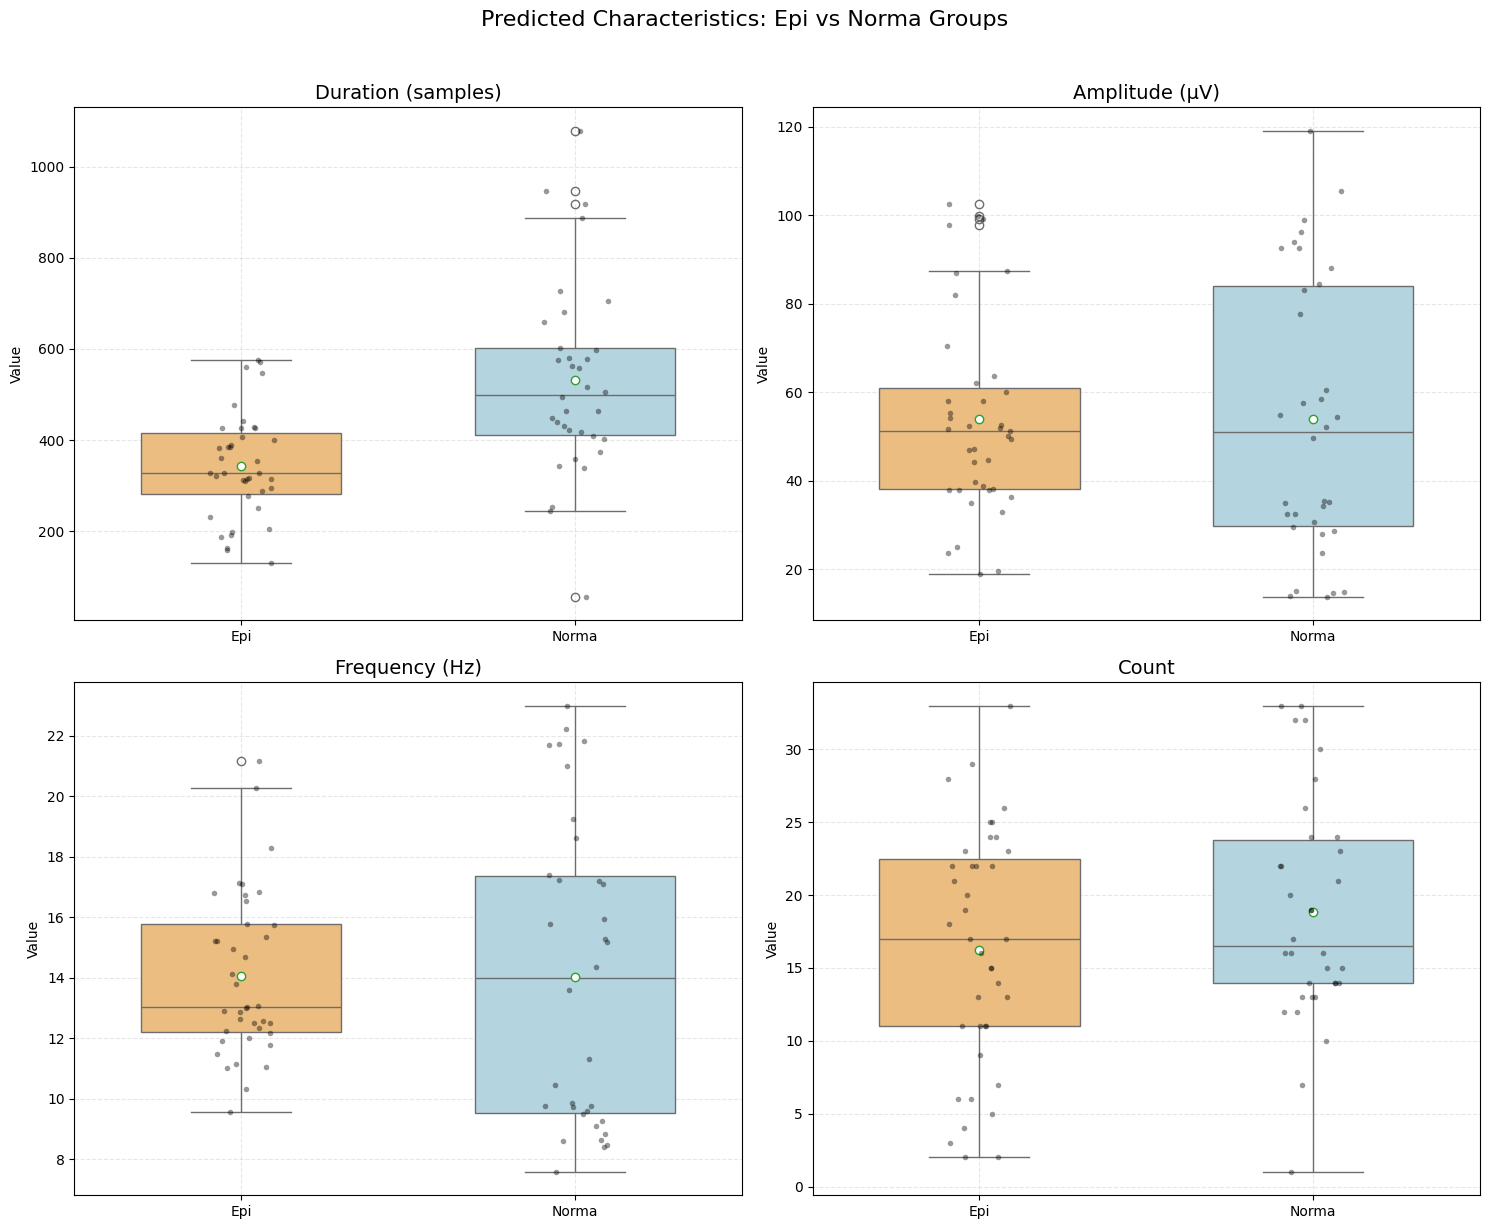

In [25]:
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    # Собираем данные
    data = {
        'Epi': unet_test_samples_char_pred_epi[:, i],
        'Norma': unet_test_samples_char_pred_norma[:, i]
    }
    
    # Boxplot с визуальными улучшениями
    sns.boxplot(data=list(data.values()), ax=ax, width=0.6,
                palette=['#fdbf6f', 'lightblue'],  # оранжевый для epi, синий для norma
                showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white'})
    
    # Добавляем точки для каждого наблюдения
    sns.stripplot(data=list(data.values()), ax=ax, 
                  color='black', alpha=0.4, size=4, jitter=True)
    
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xticklabels(data.keys())
    ax.set_ylabel('Value')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Predicted Characteristics: Epi vs Norma Groups', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
from scipy import stats

print("{:<15} {:<20} {:<20} {:<15}".format(
    'Metric', 'Epi vs Norma (true)', 'Epi vs Norma (pred)', 'Error Diff'))
print("-"*70)

for i in range(4):
    # T-test для истинных значений
    t_true, p_true = stats.ttest_ind(
        unet_test_samples_char_true_epi[:, i],
        unet_test_samples_char_true_norma[:, i],
        equal_var=False
    )
    
    # T-test для предсказаний
    t_pred, p_pred = stats.ttest_ind(
        unet_test_samples_char_pred_epi[:, i],
        unet_test_samples_char_pred_norma[:, i],
        equal_var=False
    )
    
    # T-test для ошибок
    epi_errors = np.abs(unet_dif_epi[:, i])
    norma_errors = np.abs(unet_dif_norma[:, i])
    t_err, p_err = stats.ttest_ind(epi_errors, norma_errors, equal_var=False)
    
    print("{:<15} {:<20.5f} {:<20.5f} {:<15.5f}".format(
        metrics[i].split()[0], p_true, p_pred, p_err))

Metric          Epi vs Norma (true)  Epi vs Norma (pred)  Error Diff     
----------------------------------------------------------------------
Duration        0.00004              0.00003              0.00019        
Amplitude       0.33509              0.98284              0.76224        
Frequency       0.62414              0.99313              0.30648        
Count           0.03496              0.17456              0.06352        


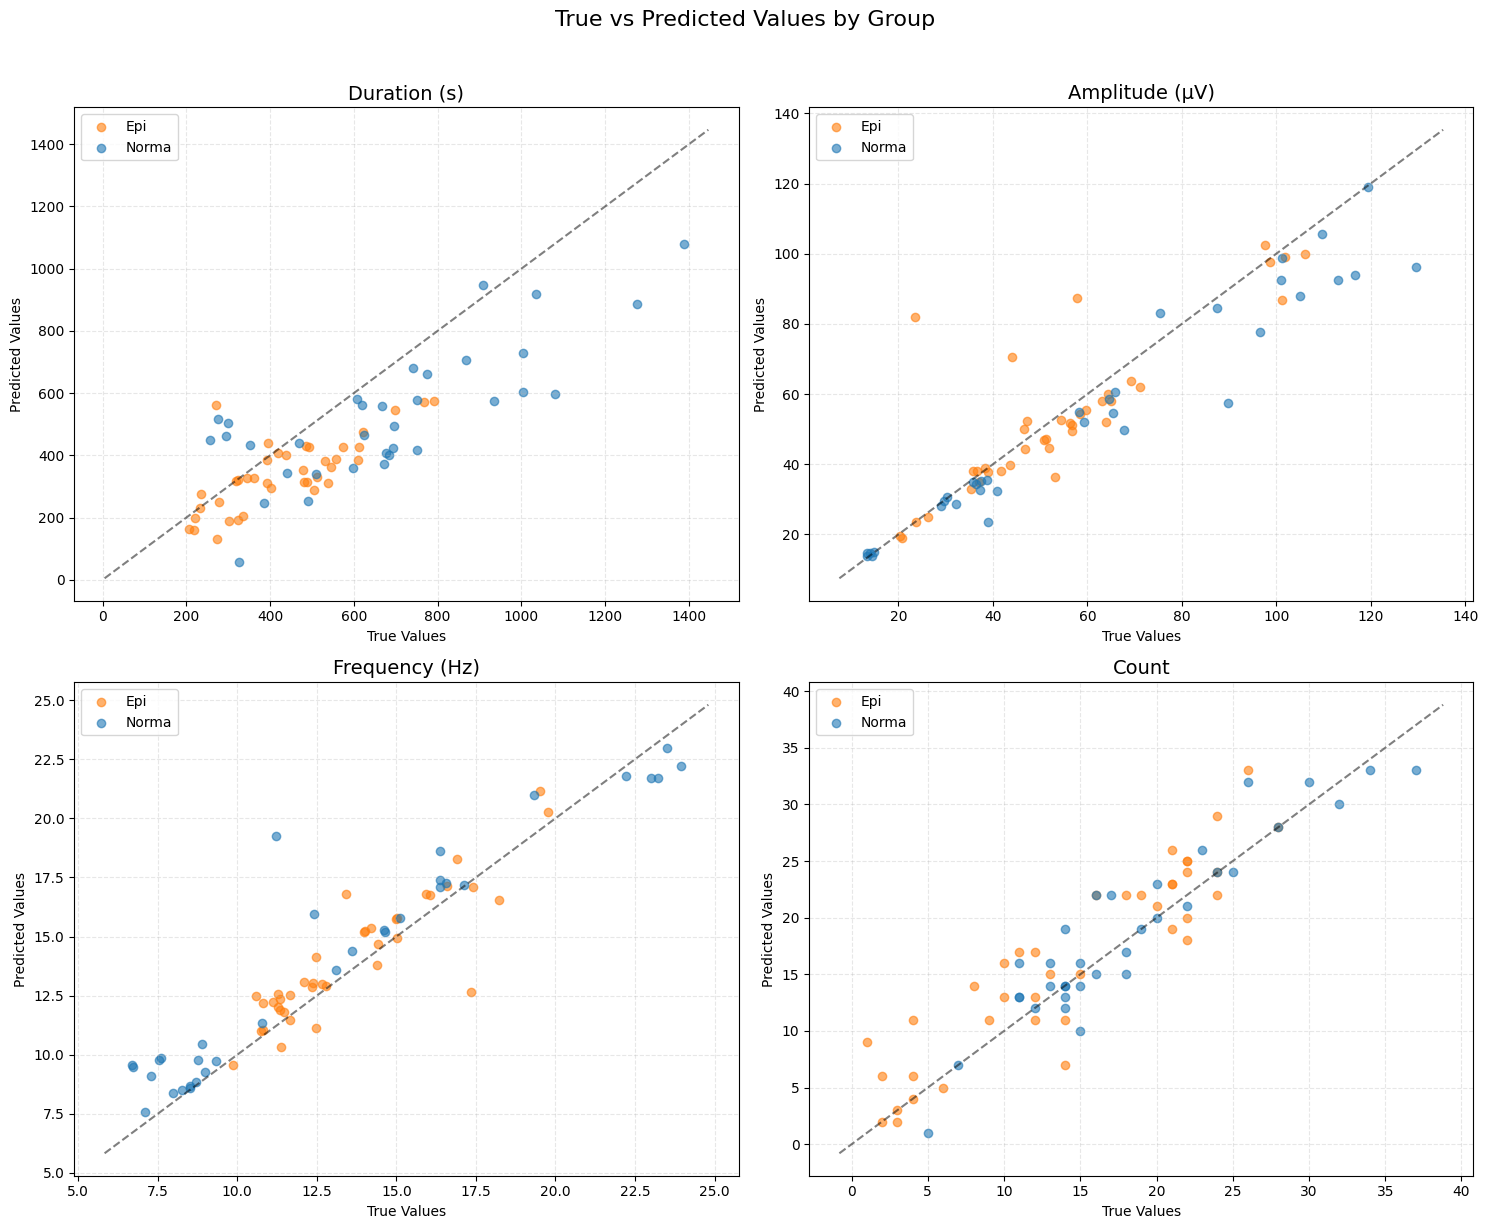

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['Duration (s)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']

for i, ax in enumerate(axes.flat):
    # Эпи-записи
    ax.scatter(unet_test_samples_char_true_epi[:, i], 
               unet_test_samples_char_pred_epi[:, i],
               color='#ff7f0e', alpha=0.6, label='Epi')
    
    # Нормальные записи
    ax.scatter(unet_test_samples_char_true_norma[:, i], 
               unet_test_samples_char_pred_norma[:, i],
               color='#1f77b4', alpha=0.6, label='Norma')
    
    # Идеальная линия
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), 
            np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('True vs Predicted Values by Group', fontsize=16, y=1.02)
plt.tight_layout()

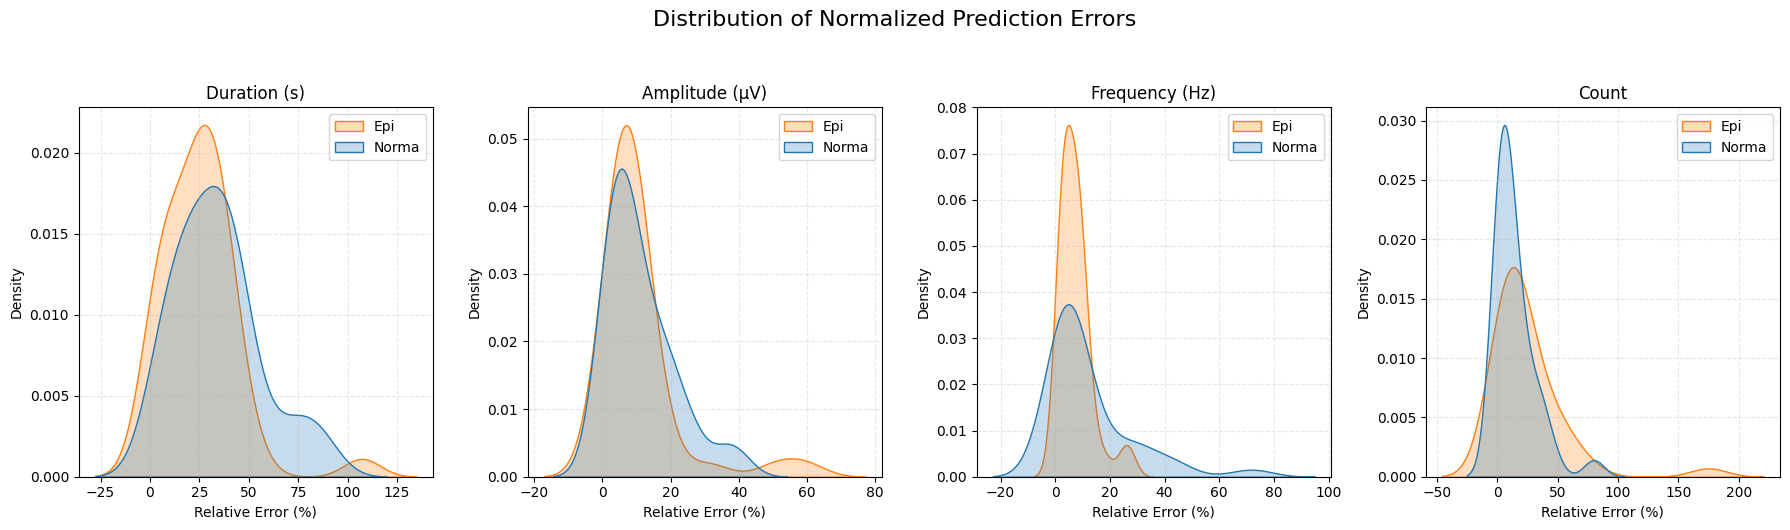

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i, ax in enumerate(axes):
    # Рассчитываем относительные ошибки
    epi_errors = (unet_dif_epi[:, i] / unet_test_samples_char_true_epi[:, i]) * 100
    norma_errors = (unet_dif_norma[:, i] / unet_test_samples_char_true_norma[:, i]) * 100
    
    # Убираем выбросы для лучшей визуализации
    epi_errors = epi_errors[np.abs(epi_errors) < 200]
    norma_errors = norma_errors[np.abs(norma_errors) < 200]
    
    sns.kdeplot(epi_errors, ax=ax, color='#ff7f0e', label='Epi', fill=True)
    sns.kdeplot(norma_errors, ax=ax, color='#1f77b4', label='Norma', fill=True)
    
    ax.set_title(metrics[i])
    ax.set_xlabel('Relative Error (%)')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Distribution of Normalized Prediction Errors', fontsize=16, y=1.05)
plt.tight_layout()

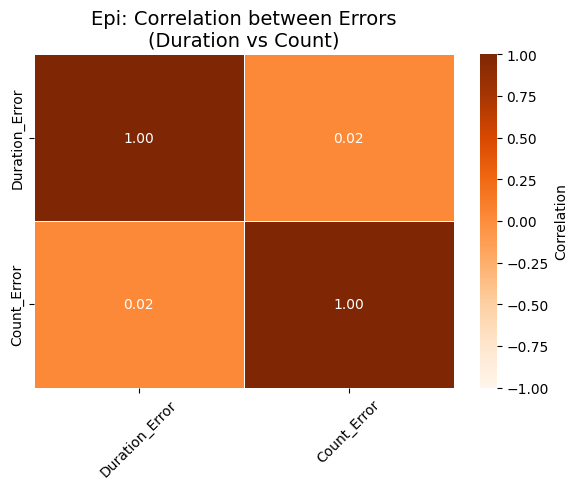

In [37]:
import pandas as pd

# Рассчитываем ошибки предсказаний
df_epi = pd.DataFrame({
    'Duration_Error': np.abs(unet_test_samples_char_pred_epi[:, 0] - unet_test_samples_char_true_epi[:, 0]),
    'Count_Error': np.abs(unet_test_samples_char_pred_epi[:, 3] - unet_test_samples_char_true_epi[:, 3]),
    'Group': 'Epi'
})

df_norma = pd.DataFrame({
    'Duration_Error': np.abs(unet_test_samples_char_pred_norma[:, 0] - unet_test_samples_char_true_norma[:, 0]),
    'Count_Error': np.abs(unet_test_samples_char_pred_norma[:, 3] - unet_test_samples_char_true_norma[:, 3]),
    'Group': 'Norma'
})

# Объединяем для удобства
df_errors = pd.concat([df_epi, df_norma])

# Корреляционная матрица для Epi
corr_epi = df_epi[['Duration_Error', 'Count_Error']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_epi, annot=True, cmap='Oranges', fmt='.2f',
            vmin=-1, vmax=1, center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Epi: Correlation between Errors\n(Duration vs Count)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

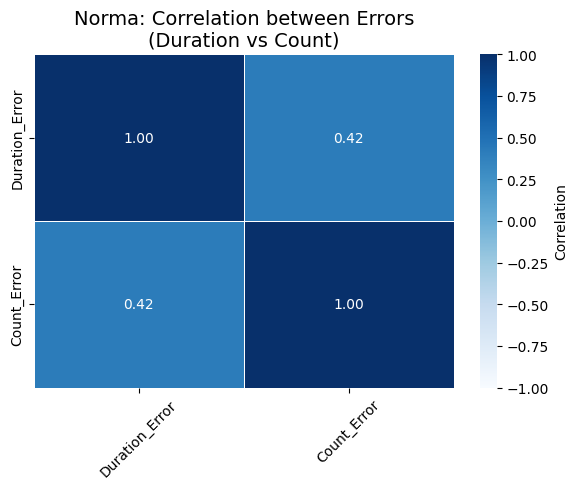

In [38]:
# Корреляционная матрица для Norma
corr_norma = df_norma[['Duration_Error', 'Count_Error']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_norma, annot=True, cmap='Blues', fmt='.2f',
            vmin=-1, vmax=1, center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Norma: Correlation between Errors\n(Duration vs Count)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()